In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import itertools
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
tqdm.pandas()

# Summary

Face recognition models are regular convolutional neural networks models. They represent face photos as vectors. We find the distance between these two vectors to compare two faces. Finally, we classify two faces as same person whose distance is less than a threshold value.

The question is that how to determine the threshold. In this notebook, we will find the best split point for a threshold.

# 1. 동양인 데이터
- 같은 사람 3000 pairs, 다른 사람 3000 pairs

In [ ]:
df1 = pd.read_csv('/content/drive/My Drive/main_proj/라젠/deepface/tests/pair_with_dist_l2.csv')
del df1['distance'], df1['distance_l2']
df1

,file_x,file_y,decision
0,/content/drive/My Drive/기업프로젝트-라젠/d...,/content/drive/My Drive/기업프로젝트-라젠/d...,Yes
1,/content/drive/My Drive/기업프로젝트-라젠/d...,/content/drive/My Drive/기업프로젝트-라젠/d...,Yes
2,/content/drive/My Drive/기업프로젝트-라젠/d...,/content/drive/My Drive/기업프로젝트-라젠/d...,Yes
3,/content/drive/My Drive/기업프로젝트-라젠/d...,/content/drive/My Drive/기업프로젝트-라젠/d...,Yes
4,/content/drive/My Drive/기업프로젝트-라젠/d...,/content/drive/My Drive/기업프로젝트-라젠/d...,Yes
...,...,...,...
5995,/content/drive/My Drive/기업프로젝트-라젠/d...,/content/drive/My Drive/기업프로젝트-라젠/d...,No
5996,/content/drive/My Drive/기업프로젝트-라젠/d...,/content/drive/My Drive/기업프로젝트-라젠/d...,No
5997,/content/drive/My Drive/기업프로젝트-라젠/d...,/content/drive/My Drive/기업프로젝트-라젠/d...,No
5998,/content/drive/My Drive/기업프로젝트-라젠/d...,/content/drive/My Drive/기업프로젝트-라젠/d...,No


In [4]:
import os
os.getcwd()
os.chdir("/content/drive/My Drive/main_proj/라젠/deepface/")

FileNotFoundError: ignored

In [ ]:
!pip install mtcnn
from deepface import DeepFace

In [ ]:
os.getcwd()
os.chdir('/content/drive/My Drive/main_proj/라젠/deepface/deepface/')

In [ ]:
import tensorflow as tf
import tensorflow_addons as tfa

instances = df1[["file_x", "file_y"]].values.tolist()
model_name = "inception"
distance_metric = "euclidean_l2"
resp_obj = DeepFace.verify(instances, model_name = model_name, distance_metric = distance_metric, enforce_detection=False)
# 1시간 걸림(6000 pairs)

In [ ]:
distances = []
for i in range(0, len(instances)):
    distance = round(resp_obj["pair_%s" % (i+1)]["distance"], 4)
    distances.append(distance)

In [ ]:
df1["distance_l2"] = distances

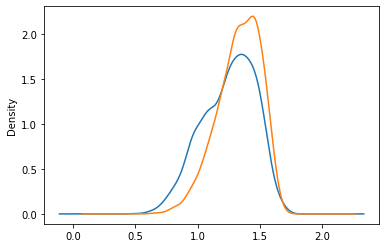

In [ ]:
df1[df1.decision == "Yes"].distance_l2.plot.kde()
df1[df1.decision == "No"].distance_l2.plot.kde()

In [ ]:
df1['distance_l2_scaled'] = -df1['distance_l2']

In [ ]:
df1

,file_x,file_y,decision,distance_l2,distance_l2_scaled
0,/content/drive/My Drive/기업프로젝트-라젠/d...,/content/drive/My Drive/기업프로젝트-라젠/d...,Yes,1.2048,-1.2048
1,/content/drive/My Drive/기업프로젝트-라젠/d...,/content/drive/My Drive/기업프로젝트-라젠/d...,Yes,0.9338,-0.9338
2,/content/drive/My Drive/기업프로젝트-라젠/d...,/content/drive/My Drive/기업프로젝트-라젠/d...,Yes,1.4160,-1.4160
3,/content/drive/My Drive/기업프로젝트-라젠/d...,/content/drive/My Drive/기업프로젝트-라젠/d...,Yes,1.3748,-1.3748
4,/content/drive/My Drive/기업프로젝트-라젠/d...,/content/drive/My Drive/기업프로젝트-라젠/d...,Yes,1.3030,-1.3030
...,...,...,...,...,...
5995,/content/drive/My Drive/기업프로젝트-라젠/d...,/content/drive/My Drive/기업프로젝트-라젠/d...,No,1.5585,-1.5585
5996,/content/drive/My Drive/기업프로젝트-라젠/d...,/content/drive/My Drive/기업프로젝트-라젠/d...,No,1.3158,-1.3158
5997,/content/drive/My Drive/기업프로젝트-라젠/d...,/content/drive/My Drive/기업프로젝트-라젠/d...,No,1.5309,-1.5309
5998,/content/drive/My Drive/기업프로젝트-라젠/d...,/content/drive/My Drive/기업프로젝트-라젠/d...,No,1.3806,-1.3806


In [ ]:
# df1.to_csv('/content/drive/My Drive/기업프로젝트-라젠/deepface/tests/outputs/pair_with_dist_Asian_6000_non_cropped_inception.csv', index=False)

# ROC curve

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve, auc
from scipy import interp
from sklearn.metrics import roc_auc_score

In [ ]:
encoder = LabelEncoder()
encoder.fit(df1['decision'])
df1['y'] = encoder.transform(df1['decision']) # 1='Yes' / 0='No'
df1['y']

0       1
1       1
2       1
3       1
4       1
       ..
5995    0
5996    0
5997    0
5998    0
5999    0
Name: y, Length: 6000, dtype: int64

In [ ]:
fpr, tpr, thresholds = roc_curve(df1['y'], df1['distance_l2_scaled'], pos_label=1)
roc_auc = auc(fpr, tpr)

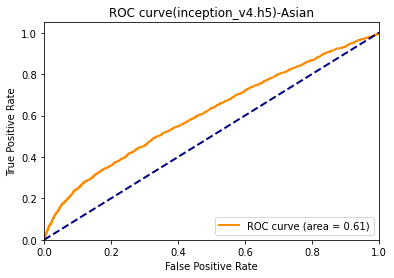

In [ ]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve(inception_v4.h5)-Asian')
plt.legend(loc="lower right")
plt.show()

# threshold
- not using k-fold

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve, auc
from scipy import interp
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier

import graphviz
from sklearn.tree import export_graphviz

In [ ]:
clf1 = DecisionTreeClassifier(max_depth=1)
X = np.array(df1['distance_l2']).reshape(-1, 1)
y = np.array(df1['y']).reshape(-1, 1)
clf1.fit(X, y)
print(clf1.score(X, y))

0.5738333333333333


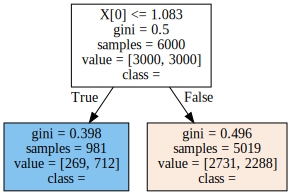

In [ ]:
export_graphviz(clf1, out_file='clf1.dot', class_names=['불일치', '일치'], impurity=True, filled=True)
with open('clf1.dot') as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

In [ ]:
threshold = clf1.tree_.threshold[0]

In [ ]:
df1["pred_euclidean_l2"] = "No"

idx = df1[df1.distance_l2 <= threshold].index
df1.loc[idx, 'pred_euclidean_l2'] = 'Yes'

In [ ]:
cm = confusion_matrix(df1.decision.values, df1.pred_euclidean_l2.values)
cm

array([[2731,  269],
       [2288,  712]])

In [ ]:
tn, fp, fn, tp = cm.ravel()
tn, fp, fn, tp

(2731, 269, 2288, 712)

In [ ]:
recall = tp / (tp + fn)
precision = tp / (tp + fp)
accuracy = (tp + tn)/(tn + fp +  fn + tp)
f1 = 2 * (precision * recall) / (precision + recall)

In [ ]:
print("Precision: ", 100*precision,"%")
print("Recall: ", 100*recall,"%")
print("F1 score ",100*f1, "%")
print("Accuracy: ", 100*accuracy,"%")

Precision:  72.579001019368 %
Recall:  23.733333333333334 %
F1 score  35.76990705852801 %
Accuracy:  57.38333333333333 %


---

# 2. lfw 데이터

In [1]:
df2 = pd.read_csv('/content/drive/My Drive/main_proj/라젠/deepface/tests/pair_with_dist_lfw.csv')
del df2['distance_l2']
df2

NameError: ignored

In [ ]:
import tensorflow as tf
import tensorflow_addons as tfa

instances = df2[["file_x", "file_y"]].values.tolist()
model_name = "inception"
distance_metric = "euclidean_l2"
resp_obj = DeepFace.verify(instances, model_name = model_name, distance_metric = distance_metric, enforce_detection=False)
# 1시간 걸림(6000 pairs)

Using inception_v4 model backend and euclidean_l2 distance.


Streaming output truncated to the last 5000 lines.

Verification:  58%|█████▊    | 3501/6000 [22:49<18:47,  2.22it/s]

Verification:  58%|█████▊    | 3502/6000 [22:49<15:29,  2.69it/s]

Verification:  58%|█████▊    | 3503/6000 [22:50<13:15,  3.14it/s]

Verification:  58%|█████▊    | 3504/6000 [22:50<11:45,  3.54it/s]

Verification:  58%|█████▊    | 3505/6000 [22:50<10:34,  3.93it/s]

Verification:  58%|█████▊    | 3506/6000 [22:50<09:55,  4.19it/s]

Verification:  58%|█████▊    | 3507/6000 [22:50<09:17,  4.47it/s]

Verification:  58%|█████▊    | 3508/6000 [22:51<08:53,  4.67it/s]

Verification:  58%|█████▊    | 3509/6000 [22:51<08:52,  4.67it/s]

Verification:  58%|█████▊    | 3510/6000 [22:52<19:06,  2.17it/s]

Verification:  59%|█████▊    | 3511/6000 [22:53<25:20,  1.64it/s]

Verification:  59%|█████▊    | 3512/6000 [22:53<20:11,  2.05it/s]

Verification:  59%|█████▊    | 3513/6000 [22:53<17:07,  2.42it/s]

Verification:  59%|█████▊    | 3514/6000 [22:53<14:22,  2.88it/s]

Verificati

In [ ]:
distances = []
for i in range(0, len(instances)):
    distance = round(resp_obj["pair_%s" % (i+1)]["distance"], 4)
    distances.append(distance)
df2["distance_l2"] = distances

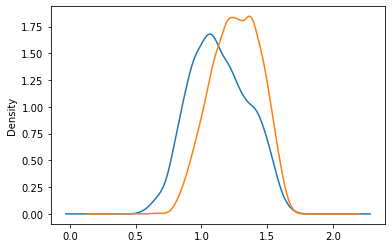

In [8]:
df2[df2.decision == "Yes"].distance_l2.plot.kde()
df2[df2.decision == "No"].distance_l2.plot.kde()

In [ ]:
# df2.to_csv('/content/drive/My Drive/기업프로젝트-라젠/deepface/tests/outputs/pair_with_dist_lfw_6000_non_cropped_inception.csv', index=False)

# ROC curve

In [ ]:
df2['distance_l2_scaled'] = -df2['distance_l2']

In [ ]:
encoder = LabelEncoder()
encoder.fit(df2['decision'])
df2['y'] = encoder.transform(df2['decision']) # 1='Yes' / 0='No'
df2['y']

0       1
1       1
2       1
3       1
4       1
       ..
5995    0
5996    0
5997    0
5998    0
5999    0
Name: y, Length: 6000, dtype: int64

In [10]:
fpr, tpr, thresholds = roc_curve(df2['y'], df2['distance_l2_scaled'], pos_label=1)
roc_auc = auc(fpr, tpr)

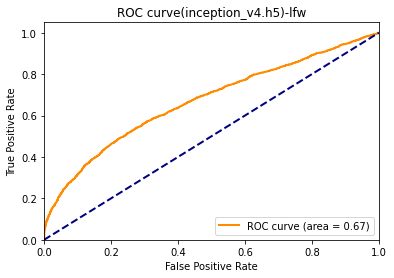

In [11]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve(inception_v4.h5)-lfw')
plt.legend(loc="lower right")
plt.show()

# Threshold

In [13]:
clf2 = DecisionTreeClassifier(max_depth=1)
X = np.array(df2['distance_l2']).reshape(-1, 1)
y = np.array(df2['y']).reshape(-1, 1)
clf2.fit(X, y)
print(clf2.score(X, y))

0.6288333333333334


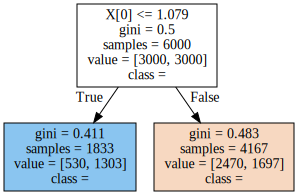

In [14]:
export_graphviz(clf2, out_file='clf2.dot', class_names=['불일치', '일치'], impurity=True, filled=True)
with open('clf2.dot') as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

In [15]:
threshold = clf2.tree_.threshold[0]

In [16]:
df2["pred_euclidean_l2"] = "No"

idx = df2[df2.distance_l2 <= threshold].index
df2.loc[idx, 'pred_euclidean_l2'] = 'Yes'

In [17]:
df2.sample(5)

,file_x,file_y,decision,distance_l2,distance_l2_scaled,y,pred_euclidean_l2
5143,/content/drive/My Drive/main_proj/라젠/deepfa...,/content/drive/My Drive/main_proj/라젠/deepfa...,No,1.1254,-1.1254,0,No
2768,/content/drive/My Drive/main_proj/라젠/deepfa...,/content/drive/My Drive/main_proj/라젠/deepfa...,Yes,0.9407,-0.9407,1,Yes
3720,/content/drive/My Drive/main_proj/라젠/deepfa...,/content/drive/My Drive/main_proj/라젠/deepfa...,No,1.4937,-1.4937,0,No
804,/content/drive/My Drive/main_proj/라젠/deepfa...,/content/drive/My Drive/main_proj/라젠/deepfa...,Yes,1.3250,-1.3250,1,No
5679,/content/drive/My Drive/main_proj/라젠/deepfa...,/content/drive/My Drive/main_proj/라젠/deepfa...,No,1.3076,-1.3076,0,No


In [18]:
cm = confusion_matrix(df2.decision.values, df2.pred_euclidean_l2.values)
cm

array([[2470,  530],
       [1697, 1303]])

In [19]:
tn, fp, fn, tp = cm.ravel()
tn, fp, fn, tp 

(2470, 530, 1697, 1303)

In [20]:
recall = tp / (tp + fn)
precision = tp / (tp + fp)
accuracy = (tp + tn)/(tn + fp +  fn + tp)
f1 = 2 * (precision * recall) / (precision + recall)

print("Precision: ", 100*precision,"%")
print("Recall: ", 100*recall,"%")
print("F1 score ",100*f1, "%")
print("Accuracy: ", 100*accuracy,"%")

Precision:  71.08565193671576 %
Recall:  43.43333333333334 %
F1 score  53.920960066211464 %
Accuracy:  62.88333333333333 %
